# 0 Preliminaries
In this section we deal with imports and parameters for the execution of the reste of the code

In [1]:
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import os
import scipy.optimize as optim

In [2]:
# Path to the folder of images
#database_path = '/home/dimitribouche/Bureau/ENSAE/CompressedSensing/CroppedYale'
database_path = '/Users/Remi/Documents/ENSAE/3A/Compressed Sensing/Reconaissance faciale/CroppedYale'
# Proportion of data to be used for learning (used for testing : 1 - learn_slice)
learn_slice = 0.5

# 1 Data base treatment
## 1.1 Read pgm function
In this subsection, we introduce a function to read the pgm images and store them in a numpy array

In [3]:
def read_pgm(pgmf):
    """
    Create a numpy array from a .pgm image file
    
    Args:
        pgmf (file) : a .pgm file opened in python
    Returns:
        numpy.ndarray. The .pgm file as a 2d numpy array
    """
    # Make sure that 
    #assert pgmf.readline() == 'P5\n'
    pgmf.readline().split()
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    image = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        image.append(row)
    return np.array(image)


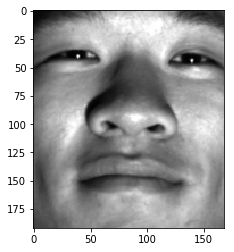

In [4]:
# Test of the read_pgm function on a given image
testfile = open(database_path + '/yaleB13/yaleB13_P00A-010E-20.pgm', 'rb')
testimage = read_pgm(testfile)

# Show the image
plt.imshow(testimage, cmap="gray")
plt.show()

## 1.2 Load full database
In this subsection, we use our pgm reader to loop over the folders and files in the database to load the full database

In [5]:
def load_database(path, flatten=True):
    """
    Load the face database from computer
    
    Args:
        path (str): the folder containing the 'CroppedYale' folder
        flatten (bool): Should images be flattened ?
    
    Returns:
        list. A list of list of numpy array. Index of first list is for the individual, 
        index of the second list is the index of the image of the individual
    """
    database = []
    count = 0
    # Each folder contains the pictures for a given individual
    # We loop over folders
    for foldername in os.listdir(path):
        # Create empty container for the images of the individual
        database.append([])
        # Loop over images
        for filename in os.listdir(path + '/' + foldername):
            # Load only images files
            if filename.endswith(".pgm"):
                # Open file
                im = open(path + '/' + foldername + '/' + filename, 'rb')
                # Convert to numpy array, jump file is conversion is not a success
                try :
                    im_np = read_pgm(im)
                except ValueError :
                    # Skip the file "ambient" which are pictures of the background of the faces, unecessary in our case
                    continue
                # Append the new image to the list of images of the individual
                if flatten:
                    database[count].append(im_np.flatten())
                else:
                    database[count].append(im_np)
        count += 1
    return database

In [6]:
# Load the Yale B extended database using our loader
data = load_database(database_path, flatten=False)

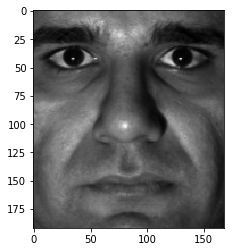

In [7]:
# Test : show a face in the database
# The index states that this is the 9th image for the 7th individual
plt.imshow(data[7][9], cmap="gray")
plt.show()

## 1.3 Division of the data in test/learn sets
In this subsection we introduce the divide_learn_test function that divide the database two : a learn set and a test set

In [8]:
def divide_learn_test(faces_data, learn_slice=0.5):
    """
    Divide the faces database into a learn set and a test set
    
    Args : 
        faces_data (list) : The database in the format of output from load_database function
        learn_slice (float) : How much of the database should be used for learning ? (0.5 : half)
    
    Returns :
        tuple. A tuple of list, the learn set and the test set
    """
    learn_data = []
    test_data = []
    for person in range(0, len(faces_data)):
        n_images = len(faces_data[person])
        shuffle(faces_data[person])
        split_index = int(learn_slice * n_images)
        learn_data.append(faces_data[person][0: split_index])
        test_data.append(faces_data[person][split_index: ])
    return learn_data, test_data

In [9]:
# Divide data base in learn and test using the divide_learn_test function
data_learn, data_test = divide_learn_test(data, learn_slice=learn_slice)

## 1.4 Stack learn data in a matrix
In this section we introduce a function to stack the learn data in a matrix

In [10]:
def stack_images(faces_data):
    dim_stacked = faces_data[0][0].shape[0] * faces_data[0][0].shape[1]
    n_images = sum([len(faces_data[i]) for i in range(0, len(faces_data))])
    images_matrix = np.zeros(shape=(dim_stacked, n_images), dtype=np.int64)
    cum_ind = 0
    for i in range(0, len(faces_data)):
        len(faces_data[i])
        for j in range(0, len(faces_data[i])):
            images_matrix[:, j + cum_ind] = faces_data[i][j].flatten().T
        cum_ind += len(faces_data[i])
    return images_matrix

In [31]:
# Create and fill the matrix of images using the stack_images function defined above
im_mat = stack_images(data_learn)
print(im_mat)
print(im_mat.shape)

[[ 47  59  65 ... 131 101   4]
 [ 50  66  67 ... 131 104   4]
 [ 54  77  72 ... 128 109   4]
 ...
 [ 30   5  22 ...   0   0   4]
 [ 29   7  28 ...   0   0   1]
 [ 31   7  32 ...   0   0   2]]
(32256, 1205)


## 1.5 Stack test data in vectors
In this section we introduce a function to stack the test data in list of vectors

In [12]:
# Create and fill the vectors of test images using the stack_images function defined above
def stack_data_to_vec(data_test):
    test_im_mat = stack_images(data_test)
    nb_cols = test_im_mat.shape[1]
    test_im_vec = []
    for i in range(0,nb_cols):
        test_im_vec.append(np.array(test_im_mat[:,i]))
    nb_test_im = len(test_im_vec)
    N = len(test_im_mat[:,0])
    return test_im_vec, nb_test_im, N

In [17]:
test_im_vec, nb_test_im, N = stack_data_to_vec(data_test)
#print(nb_test_im)
#print(N)
#print(test_im)

##Compressed sensing -- presentation of the problem (from G.Lecué notebook)
In Compressed sensing, one is given a measurement matrice $A\in\R^{m\times N}$ and a measures vector $y=Ax$ of some unknown signal $x\in\R^N$. We want to reconstruct exactly $x$ given $y$ and $A$. 

One way to look at this problem is as a highly underdetermined linear system: one has $m$ equations but $N>>m$ unknown variables. So what is going to save the day is that the signal to recover has a short support of size $s$ where $s<<N$. 

A classical procedure is the Basis Pursuit:
$$ \hat x \in\argmin_{t\in\R^N: At = y}\norm{t}_1.$$
This procedure is searching for the vector with the smallest $\ell_1$-norm in the set of solutions to the equation $Ax=y$.

##Basis Pursuit as a linear program
One can recast the Basis Pursuit procedure as a linear program. 

Let $A\in\R^{m\times N}$ be a measurements matrix and $y\in\R^m$ be a measurements vector. We consider the following linear programming problem (LP):


> $$\min_{z^+,z^-\in\bR^n} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$ [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$



For any $x\in\R^N$, we denote by  $x^+\in\R^N$ and $x^-\in\R^N$ vectors with coordinates given for any $j=1,\ldots,N$ by 
\begin{equation*}
(x^+)_j = \max(0,x_j) \mbox{ et } (x^-)_j = \max(0,-x_j).
\end{equation*} 
There is equivalence between the Basis Pursuit procedure and (LP) in the following way: 

>	If $\hat x$ is a solution to (BP) then $(\hat x^+, \hat x^-)$ is solution to (LP)

>	If $(\hat z^+, \hat z^-)$ is a solution to (LP) then $\hat z^+-\hat z^-$ is solution to (BP).

# Solving (BP) via scipy.optim.linprog

Let $A\in\bR^{m\times N}$ and $y\in\R^m$. (LP) is defined by:

> $$(\hat z^+, \hat z^-)\in\argmin_{(z^+,z^-)\in\bR^{2N}} \sum_{j=1}^n z_i^+ + z_i^-  \mbox{ subject to } [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$

Solution to (BP) is recovered via $t= \hat z^+- \hat z^-$.

Linear Programming problem considered in scipy.optim.linprog have the following form: 


Minimize:     c^T * x

Subject to:   A_ub * x <= b_ub
              A_eq * x == b_eq
              bounds[i][0] < x_i < bounds[i][1]

In the case of (LP) :

$$c = \left[\begin{array}{c} \1 \\ \1 \end{array}\right]\in\R^{2N}; \hspace{1cm} A_{eq} = [A|-A]\in\R^{m\times 2N};\hspace{1cm} b_{eq} = y\in\R^m$$

In [35]:
A = im_mat
y = test_im_vec[0]
N = A.shape[1]

c = np.ones(2*N)
A_eq=np.concatenate((A,-A), axis=1)
b_eq=y

print(A_eq.shape)
print(c.shape)
print(A.shape)
len(c)

(32256, 2410)
(2410,)
(32256, 1205)


2410

In [39]:
z=optim.linprog(c=c, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=b_eq, method='simplex')['x']
sol=z[1:N]-z[N+1:2*N]

MemoryError: 

In [37]:
plt.stem(sol)
titre = 'Représentation de la solution'
plt.title(titre)

NameError: name 'sol' is not defined